# Class Part

In [3]:
import numpy as np
from numpy import pi,cos,sin,sqrt
from numpy.linalg import inv, matrix_rank, eig
np.set_printoptions(precision=7,suppress=True)
from collections import deque
import matplotlib.pyplot as plt
import control as ct
import cv2
import time
from PIL import Image
import os

In [6]:
class FullStateFeedback():
    def __init__(self):
        self.g=9.81
        self.phyiscInterval=0.0001
        self.uIsNotTorque=False
    def CtrbObsv(self):
        print('Controllability: ',matrix_rank(ct.ctrb(self.A,self.B)))
        print('Observability: ',matrix_rank(ct.obsv(self.ATilt,self.CTilt)))
    def LQR(self, QW, RW):
        Kr, _, _ = ct.lqr(self.A,self.B,QW,RW)
        self.Kr=Kr
        print('Eigenvalue: ',eig(self.A-self.B@Kr)[0])
        self.SteadyStatePerU=-inv(self.A-self.B@self.Kr)@self.B
    def PolePlacement(self, poles):
        self.Kr=ct.place(self.A, self.B, poles)
        self.SteadyStatePerU=-inv(self.A-self.B@self.Kr)@self.B
    def SetKr(self, Kr):
        self.Kr=Kr
        print('Eigenvalue: ',eig(self.A-self.B@Kr)[0])
        temp=self.A-self.B@Kr
        if np.linalg.matrix_rank(temp)==temp.shape[0]:
            self.SteadyStatePerU=-inv(self.A-self.B@self.Kr)@self.B
        else:
            self.SteadyStatePerU=np.ones((self.A.shape[0],1))
    def SimulationSimple(self, interval=0.001, duration=4, initialState=None):
        if initialState is None:
            initialState=np.zeros((self.ATilt.shape[0],1))
        timeVector=np.linspace(0,duration,int(duration/interval+1))
        A=self.ATilt-self.BTilt@np.hstack((self.Kr,np.zeros((1,self.ATilt.shape[0]-self.A.shape[0]))))
        output=[]
        x=initialState.copy()
        for i in range(int(duration/interval+1)):
            x=(A*interval+np.identity(initialState.shape[0]))@x
            output.append(x.copy()[:,0])
        return timeVector,np.squeeze(np.array(output))
    def Simulation(self, duration=4, outputInterval=1/25, feedbackInterval=0.002, phyiscInterval=0.0005, initialState=None, QN=None, RN=None, fullState=False, estimateBias=True, setpoint=0, acceleration=5, delay=0.000, event=[], animation=False, windowH=240, windowW=427, imageScale=1000,playbackSpeed=1,exportFileName=None):
        exportFile=False
        gif = []
        if exportFileName is not None:
            fileExtension=exportFileName.split('.')[-1]
            if fileExtension=='gif':
                exportFile=True
            else:
                print("It only supports exporting GIF files.")
        if animation:
            print("Press esc to stop animation.")
        # modify interval such that each pair of interval's ratio is integer
        if duration>20:
            duration=20
            print("Maximum duration is 20 seconds.")
        outputNumber=max(1,round(duration/outputInterval))
        outputInterval=duration/outputNumber
        feedbackNumber=max(1,round(outputInterval/feedbackInterval))
        feedbackInterval=outputInterval/feedbackNumber
        physicNumber=max(1,round(feedbackInterval/phyiscInterval))
        phyiscInterval=feedbackInterval/physicNumber
        self.phyiscInterval=phyiscInterval

        # initialize QN and RN
        if initialState is None:
            initialState=np.zeros((self.ATilt.shape[0],1))
        if QN is None:
            QN=[0.00001]*self.A.shape[0]+[0.000001]*(self.ATilt.shape[0]-self.A.shape[0])
            QN=np.diag(QN)
        if RN is None:
            RN=[0.00001]*self.C.shape[0]
            RN=np.diag(RN)
        if type(QN) is not np.ndarray and type(RN) is not np.ndarray and QN==0 and RN==0:
            fullState=True
        if type(QN) is not np.ndarray:
            QN=[QN]*self.ATilt.shape[0]
            QN=np.diag(QN)
        if type(RN) is not np.ndarray:
            RN=[RN]*self.C.shape[0]
            RN=np.diag(RN)
        QN=QN*feedbackInterval

        # x,xhat and matrix in kalman filter
        if estimateBias:
            F=np.eye(self.ATilt.shape[0])+feedbackInterval*self.ATilt
            B=feedbackInterval*self.BTilt
            H=self.CTilt
            Pk=[0.001]*self.A.shape[0]+[1]*(self.ATilt.shape[0]-self.A.shape[0])
            QN_KF=QN
        else:
            F=np.eye(self.A.shape[0])+feedbackInterval*self.A
            B=feedbackInterval*self.B
            H=self.C
            Pk=[0.001]*self.A.shape[0]
            QN_KF=QN[:self.A.shape[0],:self.A.shape[0]]
        Pk=np.diag(Pk)
        x=initialState.copy()
        xhat=np.zeros(x.shape)

        # something
        ud=self.Ud(setpoint)
        u=0
        u_new=0
        targetSpeed=0
        q=deque()
        last_update_time=time.time()-outputInterval
        eventIndex=0
        timeVector=np.linspace(0,outputInterval,feedbackNumber)
        delta=0
        deltaList=[delta]
        outputIndex=-1
        looped=False

        # output list and first frame animation
        outputState=[x.copy()]
        outputStateHat=[xhat.copy()]
        outputTorque=[0]
        if animation:
            WINDOW_NAME="Test"
            cv2.namedWindow(WINDOW_NAME)
            self.UpdateAnimation(x,delta,WINDOW_NAME,windowH,windowW,imageScale)

        while True:
            current_time = time.time()
            if not animation or ((current_time - last_update_time) >= outputInterval/playbackSpeed):
                outputIndex+=1
                if outputIndex>=outputNumber:
                    if not animation:
                        break
                    else:
                        looped=True
                        outputIndex=0
                if animation and looped:
                    self.UpdateAnimation(outputState[outputIndex],deltaList[outputIndex],WINDOW_NAME,windowH,windowW,imageScale)
                else:
                    noiseQN=ct.white_noise(timeVector,QN,dt=feedbackInterval).T
                    noiseRN=ct.white_noise(timeVector,RN,dt=feedbackInterval).T
                    torqueAvg=0
                    for feedbackIndex in range(feedbackNumber):
                        if len(event)>eventIndex and event[eventIndex][0]<=feedbackInterval*feedbackIndex+outputIndex*outputInterval:
                            if event[eventIndex][1]=='setpoint':
                                setpoint=event[eventIndex][2]
                                ud=self.Ud(setpoint)
                            elif event[eventIndex][1]=='disturbance':
                                disturbance=event[eventIndex][2]
                                if x.shape[0]==disturbance.shape[0] and x.shape[1]==disturbance.shape[1]:
                                    x+=disturbance
                                else:
                                    print('Disturbance is in wrong shape')
                            else:
                                print('Unknown event')
                            eventIndex+=1
                        x,d=x[:self.A.shape[0],:],x[self.A.shape[0]:]
                        for _ in range(physicNumber):
                            if self.uIsNotTorque:
                                if u_new-u>acceleration*phyiscInterval:
                                    acc=acceleration
                                    u+=acceleration*phyiscInterval
                                elif u_new-u<acceleration*phyiscInterval:
                                    acc=-acceleration
                                    u-=acceleration*phyiscInterval
                                else:
                                    acc=(u_new-u)/phyiscInterval
                                    u=u_new
                                torque=self.TorqueFromAcc(x,acc)
                                torqueAvg+=torque
                                x+=self.dXdt(x,acc)*phyiscInterval
                            else:
                                if targetSpeed-self.CurrentSpeed(x)>acceleration*phyiscInterval:
                                    acc=acceleration
                                elif targetSpeed-self.CurrentSpeed(x)<-acceleration*phyiscInterval:
                                    acc=-acceleration
                                else:
                                    acc=(targetSpeed-self.CurrentSpeed(x))/phyiscInterval
                                torque=self.TorqueFromAcc(x,acc)
                                torqueAvg+=torque
                                x+=self.dXdt(x,torque)*phyiscInterval
                        x=np.vstack((x,d))
                        x+=np.expand_dims(noiseQN[feedbackIndex],1)
                        y=self.CTilt@x+np.expand_dims(noiseRN[feedbackIndex],1)
                        delta+=self.IntegralVelocity(x)*feedbackInterval

                        if fullState:
                            # full-state feedback
                            xhat=x
                        else:
                            if not estimateBias:
                                xhat,d=xhat[:self.A.shape[0],:],xhat[self.A.shape[0]:]
                            # kalman filter
                            xcheck=F@xhat+B*u
                            Pcheck=F@Pk@F.T+QN_KF
                            K=Pcheck@H.T@inv(H@Pcheck@H.T+np.identity(H.shape[0])*RN)
                            xhat=xcheck+K@(y-H@xcheck)
                            Pk=(np.identity(F.shape[0])-K@H)@Pcheck
                            if not estimateBias:
                                xhat=np.vstack((xhat,d))
                        q.append((-self.Kr@xhat[:self.Kr.shape[1],:]+ud)[0,0])
                        if len(q)>round(delay/feedbackInterval):
                            u_new=q.popleft()
                        acc=self.AccFromU(xhat[:self.A.shape[1],:],u_new)
                        targetSpeed=self.CurrentSpeed(xhat[:self.A.shape[1],:])+acc*feedbackInterval
                        if not self.uIsNotTorque:
                            u=u_new
                    outputState.append(x.copy())
                    outputStateHat.append(xhat.copy())
                    outputTorque.append(torqueAvg/feedbackNumber/physicNumber)
                    deltaList.append(delta)
                    if animation:
                        img=self.UpdateAnimation(x,delta,WINDOW_NAME,windowH,windowW,imageScale)
                        if not looped and exportFile:
                            gif.append(Image.fromarray(img[...,::-1]))
                last_update_time = current_time

            if animation:
                # Handle user input
                key = cv2.waitKey(1) & 0xFF
                if key == 27:  # ESC key
                    break
        cv2.destroyAllWindows()
        if animation and exportFile:
            dir_path="/".join(exportFileName.split('/')[:-1])
            if not os.path.exists(dir_path):
                os.makedirs(dir_path)
            gif[0].save(exportFileName, save_all=True, append_images=gif[1:], duration=round(outputInterval*1000), loop=0, disposal=0)
        outputIndex=len(outputState)-1
        return np.linspace(0,outputIndex*outputInterval,outputIndex+1),np.squeeze(np.array(outputState)),np.squeeze(np.array(outputStateHat)),np.squeeze(np.array(outputTorque))

# region models
class InvertedPendulumOnWheel(FullStateFeedback):
    def __init__(self,m,m_w,R,L,I,I_w,Br,Bm): # define A,B,C
        super().__init__()
        self.m=self.m_m=m
        self.m_w=self.m_m_w=m_w
        self.R=self.m_R=R
        self.L=self.m_L=L
        self.I=self.m_I=I
        self.I_w=self.m_I_w=I_w
        self.Br=self.m_Br=Br
        self.Bm=self.m_Bm=Bm
        G_1=inv(np.array([
            [I_w+(m_w+m)*R**2,m*R*L],
            [m*R*L,I+m*L**2]
        ]))
        A_lower=G_1@np.array([
            [0,-Bm-Br,Bm],
            [m*self.g*L,Bm,-Bm]
        ])
        self.A=np.vstack((np.array([[0,0,1]]),A_lower))
        self.B=np.vstack((np.array([[0]]),G_1@np.array([[1],[-1]])))
        self.C=np.array([[1,0,0]])
        self.dot2state=np.array([[0,0,1],[0,0,0],[0,0,0]])
        self.acc2state=np.array([[0,0],[1,0],[0,1]])
        ATilt=np.zeros((4,4))
        ATilt[:3,:3]=self.A
        self.ATilt=ATilt
        self.BTilt=np.vstack((self.B,np.zeros((1,1))))
        self.CTilt=np.hstack((self.C,np.array([[1]])))
        self.State()
        self.CtrbObsv()
    def State(self):
        print('State: theta, phidot, thetadot, thetaBias')
        print('Input: torque in the "phi-theta" direction')
        print('output: theta')
        print('set point state: phidot')
    def Ud(self,setpoint):
        # set the phidot to setpoint
        if self.SteadyStatePerU[1][0]==0:
            return 0
        return setpoint/self.SteadyStatePerU[1][0]
    def CurrentSpeed(self,x):
        theta,phidot,thetadot=x.flatten()
        return phidot-thetadot
    def TorqueFromAcc(self,x,acc):
        theta,phidot,thetadot=x.flatten()
        G_1=np.array([
            [self.I+self.m*self.L**2,-self.m*self.R*self.L*cos(theta)],
            [-self.m*self.R*self.L*cos(theta),self.I_w+(self.m_w+self.m)*self.R**2]
        ])/((self.I_w+(self.m_w+self.m)*self.R**2)*(self.I+self.m*self.L**2)-(self.m*self.R*self.L*cos(theta))**2)
        H=np.array([
            [-(self.Br+self.Bm)*phidot+self.Bm*thetadot+self.m*self.R*self.L*sin(theta)*thetadot*thetadot],
            [self.Bm*phidot-self.Bm*thetadot+self.m*self.g*self.L*sin(theta)]
        ])
        return ((acc-np.array([[1,-1]])@G_1@H)/(np.array([[1,-1]])@G_1@np.array([[1],[-1]])))[0,0]
    def AccFromU(self,x,tau):
        theta,phidot,thetadot=x.flatten()
        m=self.m_m
        m_w=self.m_m_w
        R=self.m_R
        L=self.m_L
        I=self.m_I
        I_w=self.m_I_w
        Br=self.m_Br
        Bm=self.m_Bm
        G_1=np.array([
            [I+m*L**2,-m*R*L*cos(theta)],
            [-m*R*L*cos(theta),I_w+(m_w+m)*R**2]
        ])/((I_w+(m_w+m)*R**2)*(I+m*L**2)-(m*R*L*cos(theta))**2)
        H=np.array([
            [-(Br+Bm)*phidot+Bm*thetadot+m*R*L*sin(theta)*thetadot*thetadot+tau],
            [Bm*phidot-Bm*thetadot+m*self.g*L*sin(theta)-tau]
        ])
        return (np.array([[1,-1]])@G_1@H)[0,0]
    def dXdt(self,x,tau):
        theta,phidot,thetadot=x.flatten()
        G_1=np.array([
            [self.I+self.m*self.L**2,-self.m*self.R*self.L*cos(theta)],
            [-self.m*self.R*self.L*cos(theta),self.I_w+(self.m_w+self.m)*self.R**2]
        ])/((self.I_w+(self.m_w+self.m)*self.R**2)*(self.I+self.m*self.L**2)-(self.m*self.R*self.L*cos(theta))**2)
        H=np.array([
            [-(self.Br+self.Bm)*phidot+self.Bm*thetadot+self.m*self.R*self.L*sin(theta)*thetadot*thetadot+tau],
            [self.Bm*phidot-self.Bm*thetadot+self.m*self.g*self.L*sin(theta)-tau]
        ])
        return self.dot2state@x+self.acc2state@G_1@H
    def IntegralVelocity(self,x):
        return x[1,0]
    def UpdateAnimation(self,x,delta,WINDOW_NAME,windowH,windowW,imageScale):
        theta=x[0,0]
        img = np.zeros((windowH,windowW, 3), np.uint8)
        contours=[]
        offset=np.array([[(windowW/2+self.R*delta*imageScale)%windowW,windowH-self.R*imageScale]])
        rect = np.array([
            [-10,-2*self.L*imageScale],
            [-10,0],
            [10,0],
            [10,-2*self.L*imageScale]
        ])
        Rotation=np.array([
            [cos(theta),-sin(theta)],
            [sin(theta),cos(theta)]
        ])
        rect=(rect@Rotation.T+offset).astype(np.int64)
        contours.append(rect)
        cv2.drawContours(img, contours, -1, (0,255,0), -1, cv2.LINE_AA)
        circleCenter=offset.astype(np.int64)
        cv2.circle(img,(circleCenter[0,0],circleCenter[0,1]),int(self.R*imageScale),(255,255,255),-1)
        Rotation=np.array([
            [cos(delta),-sin(delta)],
            [sin(delta),cos(delta)]
        ])
        circleHand=np.array([[0,self.R*imageScale]])
        circleHand=(circleHand@Rotation.T).astype(np.int64)
        cv2.line(img,(circleCenter[0,0],circleCenter[0,1]),(circleCenter[0,0]+circleHand[0,0],circleCenter[0,1]+circleHand[0,1]),(0,0,255),5)
        cv2.imshow(WINDOW_NAME, img)
        return img
class ReactionWheelOnInvertedPendulum(FullStateFeedback):
    def __init__(self,m,m_w,L,L_w,I,I_w,Ba,Bm): # define A,B,C
        super().__init__()
        self.m=self.m_m=m
        self.m_w=self.m_m_w=m_w
        self.L=self.m_L=L
        self.L_w=self.m_L_w=L_w
        self.I=self.m_I=I
        self.I_w=self.m_I_w=I_w
        self.Ba=self.m_Ba=Ba
        self.Bm=self.m_Bm=Bm
        self.A=np.array([
            [0,0,1],
            [0,-Bm/I_w,Bm/I_w],
            [(m*L+m_w*L_w)*self.g/(I+m*L**2+m_w*L_w**2),Bm/(I+m*L**2+m_w*L_w**2),(-Bm-Ba)/(I+m*L**2+m_w*L_w**2)]
        ])
        self.B=np.array([[0],[1/I_w],[-1/(I+m*L**2+m_w*L_w**2)]])
        self.C=np.array([[1,0,0],[0,1,-1]])
        ATilt=np.zeros((4,4))
        ATilt[:3,:3]=self.A
        self.ATilt=ATilt
        self.BTilt=np.vstack((self.B,np.zeros((1,1))))
        self.CTilt=np.hstack((self.C,np.array([[1],[0]])))
        self.State()
        self.CtrbObsv()
    def State(self):
        print('State: theta, phidot, thetadot, thetaBias')
        print('Input: torque in the "phi-theta" direction')
        print('output: theta, phidot-thetadot')
        print('set point state: phidot')
    def Ud(self,setpoint):
        # set the phidot state to setpoint
        if self.SteadyStatePerU[1][0]==0:
            return 0
        return setpoint/self.SteadyStatePerU[1][0]
    def CurrentSpeed(self,x):
        theta,phidot,thetadot=x.flatten()
        return phidot-thetadot
    def TorqueFromAcc(self,x,acc):
        theta,phidot,thetadot=x.flatten()
        numerator=acc-(-self.Bm*phidot+self.Bm*thetadot)/self.I_w-(self.Bm*phidot-(self.Bm+self.Ba)*thetadot+(self.m*self.L+self.m_w*self.L_w)*self.g*sin(theta))/(self.I+self.m_w*self.L_w**2+self.m*self.L**2)
        denominator=-1/(self.I+self.m_w*self.L_w**2+self.m*self.L**2)+1/self.I_w
        return numerator/denominator
    def AccFromU(self,x,tau):
        theta,phidot,thetadot=x.flatten()
        m=self.m_m
        m_w=self.m_m_w
        L=self.m_L
        L_w=self.m_L_w
        I=self.m_I
        I_w=self.m_I_w
        Ba=self.m_Ba
        Bm=self.m_Bm
        phidot2=(-Bm*phidot+Bm*thetadot+tau)/I_w
        thetadot2=(Bm*phidot-(Bm+Ba)*thetadot+(m*L+m_w*L_w)*self.g*sin(theta)-tau)/(I+m_w*L_w**2+m*L**2)
        return phidot2-thetadot2
    def dXdt(self,x,tau):
        theta,phidot,thetadot=x.flatten()
        phidot2=(-self.Bm*phidot+self.Bm*thetadot+tau)/self.I_w
        thetadot2=(self.Bm*phidot-(self.Bm+self.Ba)*thetadot+(self.m*self.L+self.m_w*self.L_w)*self.g*sin(theta)-tau)/(self.I+self.m_w*self.L_w**2+self.m*self.L**2)
        return np.array([[thetadot,phidot2,thetadot2]]).T
    def IntegralVelocity(self,x):
        return x[1,0]
    def UpdateAnimation(self,x,delta,WINDOW_NAME,windowH,windowW,imageScale):
        theta=x[0,0]
        rw=50
        img = np.zeros((windowH,windowW, 3), np.uint8)
        contours=[]
        offset=np.array([[windowW/2,windowH]])
        rect = np.array([
            [-10,-self.L_w*imageScale],
            [-10,0],
            [10,0],
            [10,-self.L_w*imageScale]
        ])
        Rotation=np.array([
            [cos(theta),-sin(theta)],
            [sin(theta),cos(theta)]
        ])
        rect=(rect@Rotation.T+offset).astype(np.int64)
        contours.append(rect)
        cv2.drawContours(img, contours, -1, (0,255,0), -1, cv2.LINE_AA)
        circleCenter=np.array([[0,-self.L_w]])*imageScale
        circleCenter=(circleCenter@Rotation.T+offset).astype(np.int64)
        cv2.circle(img,(circleCenter[0,0],circleCenter[0,1]),rw,(255,255,255),-1)
        Rotation=np.array([
            [cos(delta),-sin(delta)],
            [sin(delta),cos(delta)]
        ])
        circleHand=np.array([[0,rw]])
        circleHand=(circleHand@Rotation.T).astype(np.int64)
        cv2.line(img,(circleCenter[0,0],circleCenter[0,1]),(circleCenter[0,0]+circleHand[0,0],circleCenter[0,1]+circleHand[0,1]),(0,0,255),5)
        cv2.imshow(WINDOW_NAME, img)
        return img
class InvertedPendulumOnCart(FullStateFeedback):
    def __init__(self,mc,m1,l1,I1,b1,R): # define A,B,C
        super().__init__()
        self.mc=self.m_mc=mc
        self.m1=self.m_m1=m1
        self.l1=self.m_l1=l1
        self.I1=self.m_I1=I1
        self.b1=self.m_b1=b1
        self.R=self.m_R=R

        G_1=inv(np.array([
            [m1+mc,1/2*m1*l1],
            [1/2*m1*l1,1/4*m1*l1**2+I1]
        ]))
        A_lower=G_1@(np.array([
            [0,1/2*m1*self.g*l1],
            [0,0],
            [0,-b1]
        ]).T)
        B_lower=G_1@np.array([[1/R],[0]])
        self.A=np.vstack((np.array([0,0,1]),A_lower))
        self.B=np.vstack((np.array([[0]]),B_lower))
        self.C=np.array([[1,0,0],[0,1,0]])
        self.dot2state=np.array([[0,0,1],[0,0,0],[0,0,0]])
        self.acc2state=np.array([[0,0],[1,0],[0,1]])
        ATilt=np.zeros((4,4))
        ATilt[:3,:3]=self.A
        self.ATilt=ATilt
        self.BTilt=np.vstack((self.B,np.zeros((1,1))))
        self.CTilt=np.hstack((self.C,np.array([[1],[0]])))
        self.State()
        self.CtrbObsv()
    def State(self):
        print('State: theta, xdot, thetadot, thetaBias')
        print('Input: torque = R * force on x direction')
        print('output: theta, xdot')
        print('set point state: xdot')
    def Ud(self,setpoint):
        # set the xdot state to setpoint
        if self.SteadyStatePerU[1][0]==0:
            return 0
        return setpoint/self.SteadyStatePerU[1][0]
    def CurrentSpeed(self,x):
        theta,xdot,thetadot=x.flatten()
        return xdot/self.R
    def TorqueFromAcc(self,x,acc):
        theta,xdot,thetadot=x.flatten()
        G_1=np.array([
            [1/4*self.m1*self.l1**2+self.I1,-1/2*self.m1*self.l1*cos(theta)],
            [-1/2*self.m1*self.l1*cos(theta),self.m1+self.mc]
        ])/(1/4*self.mc*self.m1*self.l1**2+self.I1*(self.mc+self.m1))
        H=np.array([
            [1/2*self.m1*self.l1*thetadot**2*sin(theta)],
            [1/2*self.m1*self.g*self.l1*sin(theta)-self.b1*thetadot]
        ])
        return ((acc*self.R-np.array([[1,0]])@G_1@H)*self.R/(np.array([[1,0]])@G_1@np.array([[1],[0]])))[0,0]
    def AccFromU(self,x,tau):
        theta,xdot,thetadot=x.flatten()
        mc=self.m_mc
        m1=self.m_m1
        l1=self.m_l1
        I1=self.m_I1
        b1=self.m_b1
        R=self.m_R
        G_1=np.array([
            [1/4*m1*l1**2+I1,-1/2*m1*l1*cos(theta)],
            [-1/2*m1*l1*cos(theta),m1+mc]
        ])/(1/4*mc*m1*l1**2+I1*(mc+m1))
        H=np.array([
            [tau/R+1/2*m1*l1*thetadot**2*sin(theta)],
            [1/2*m1*self.g*l1*sin(theta)-b1*thetadot]
        ])
        return 1/R*(np.array([[1,0]])@G_1@H)[0,0]
    def dXdt(self,x,tau):
        theta,xdot,thetadot=x.flatten()
        G_1=np.array([
            [1/4*self.m1*self.l1**2+self.I1,-1/2*self.m1*self.l1*cos(theta)],
            [-1/2*self.m1*self.l1*cos(theta),self.m1+self.mc]
        ])/(1/4*self.mc*self.m1*self.l1**2+self.I1*(self.mc+self.m1))
        H=np.array([
            [tau/self.R+1/2*self.m1*self.l1*thetadot**2*sin(theta)],
            [1/2*self.m1*self.g*self.l1*sin(theta)-self.b1*thetadot]
        ])
        return self.dot2state@x+self.acc2state@G_1@H
    def IntegralVelocity(self,x):
        return x[1,0]
    def UpdateAnimation(self,x,delta,WINDOW_NAME,windowH,windowW,imageScale):
        theta=x[0,0]
        img = np.zeros((windowH,windowW, 3), np.uint8)
        contours=[]
        offset=np.array([[(windowW/2+delta*imageScale)%windowW,windowH-10]])
        cartCenter=offset.astype(np.int64)
        cv2.rectangle(img,(cartCenter[0,0]-30,cartCenter[0,1]-10),(cartCenter[0,0]+30,cartCenter[0,1]+10),(255,255,255),-1)
        rect = np.array([
            [-10,-self.l1*imageScale],
            [-10,0],
            [10,0],
            [10,-self.l1*imageScale]
        ])
        Rotation=np.array([
            [cos(theta),-sin(theta)],
            [sin(theta),cos(theta)]
        ])
        rect=(rect@Rotation.T+offset).astype(np.int64)
        contours.append(rect)
        cv2.drawContours(img, contours, -1, (0,255,0), -1, cv2.LINE_AA)
        cv2.imshow(WINDOW_NAME, img)
        return img
class DoubleInvertedPendulumOnCart(FullStateFeedback):
    def __init__(self,mc,m1,l1,I1,b1,m2,l2,I2,b2,R): # define A,B,C
        super().__init__()
        self.mc=self.m_mc=mc
        self.m1=self.m_m1=m1
        self.l1=self.m_l1=l1
        self.I1=self.m_I1=I1
        self.b1=self.m_b1=b1
        self.m2=self.m_m2=m2
        self.l2=self.m_l2=l2
        self.I2=self.m_I2=I2
        self.b2=self.m_b2=b2
        self.R=self.m_R=R

        G_00=mc+m1+m2
        G_01=(1/2*m1+m2)*l1
        G_02=1/2*m2*l2
        G_11=(1/4*m1+m2)*l1**2+I1
        G_12=1/2*m2*l1*l2
        G_22=1/4*m2*l2**2+I2
        G_1=inv(np.array([
            [G_00,G_01,G_02],
            [G_01,G_11,G_12],
            [G_02,G_12,G_22],
            
        ]))
        A_lower=G_1@(np.array([
            [0,(1/2*m1+m2)*self.g*l1,0],
            [0,0,1/2*m2*self.g*l2],
            [0,0,0],
            [0,-b1,b2],
            [0,0,-b2]
        ]).T)
        B_lower=G_1@np.array([[1/R],[0],[0]])
        # state = theta,phi,xdot,thetadot,phidot
        self.A=np.vstack((np.hstack((np.zeros((2,3)),np.identity(2))),A_lower))
        self.B=np.vstack((np.array([[0],[0]]),B_lower))
        self.C=np.array([[1,0,0,0,0],[-1,1,0,0,0],[0,0,1,0,0]])
        self.dot2state=np.array([[0,0,0,1,0],[0,0,0,0,1],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]])
        self.acc2state=np.array([[0,0,0],[0,0,0],[1,0,0],[0,1,0],[0,0,1]])        
        self.ATilt=self.A
        self.BTilt=self.B
        self.CTilt=self.C
        self.State()
        self.CtrbObsv()
    def State(self):
        print('State: theta, phi, xdot, thetadot, phidot')
        print('Input: torque = R * force on x direction')
        print('output: theta, phi-theta, xdot')
        print('set point state: xdot')
    def Ud(self,setpoint):
        # set the xdot to setpoint
        if self.SteadyStatePerU[2][0]==0:
            return 0
        return setpoint/self.SteadyStatePerU[2][0]
    def CurrentSpeed(self,x):
        theta,phi,xdot,thetadot,phidot=x.flatten()
        return xdot/self.R
    def TorqueFromAcc(self,x,acc):
        theta,phi,xdot,thetadot,phidot=x.flatten()
        G_00=self.mc+self.m1+self.m2
        G_01=(1/2*self.m1+self.m2)*self.l1*cos(theta)
        G_02=1/2*self.m2*self.l2*cos(phi)
        G_11=(1/4*self.m1+self.m2)*self.l1**2+self.I1
        G_12=1/2*self.m2*self.l1*self.l2*cos(phi-theta)
        G_22=1/4*self.m2*self.l2**2+self.I2
        G_1=inv(np.array([
            [G_00,G_01,G_02],
            [G_01,G_11,G_12],
            [G_02,G_12,G_22],
        ]))
        H=np.array([
            [(1/2*self.m1+self.m2)*self.l1*sin(theta)*thetadot**2+1/2*self.m2*self.l2*sin(phi)*phidot**2],
            [1/2*self.m2*self.l1*self.l2*sin(phi-theta)*phidot**2+(1/2*self.m1+self.m2)*self.g*self.l1*sin(theta)-self.b1*thetadot],
            [-1/2*self.m2*self.l1*self.l2*sin(phi-theta)*thetadot**2+1/2*self.m2*self.g*self.l2*sin(phi)-self.b2*(phidot-thetadot)]
        ])
        return ((acc*self.R-np.array([[1,0,0]])@G_1@H)*self.R/(np.array([[1,0,0]])@G_1@np.array([[1],[0],[0]])))[0,0]
    def AccFromU(self,x,tau):
        theta,phi,xdot,thetadot,phidot=x.flatten()
        mc=self.m_mc
        m1=self.m_m1
        l1=self.m_l1
        I1=self.m_I1
        b1=self.m_b1
        m2=self.m_m2
        l2=self.m_l2
        I2=self.m_I2
        b2=self.m_b2
        R=self.m_R
        G_00=mc+m1+m2
        G_01=(1/2*m1+m2)*l1*cos(theta)
        G_02=1/2*m2*l2*cos(phi)
        G_11=(1/4*m1+m2)*l1**2+I1
        G_12=1/2*m2*l1*l2*cos(phi-theta)
        G_22=1/4*m2*l2**2+I2
        G_1=inv(np.array([
            [G_00,G_01,G_02],
            [G_01,G_11,G_12],
            [G_02,G_12,G_22],
        ]))
        H=np.array([
            [tau/R+(1/2*m1+m2)*l1*sin(theta)*thetadot**2+1/2*m2*l2*sin(phi)*phidot**2],
            [1/2*m2*l1*l2*sin(phi-theta)*phidot**2+(1/2*m1+m2)*self.g*l1*sin(theta)-b1*thetadot],
            [-1/2*m2*l1*l2*sin(phi-theta)*thetadot**2+1/2*m2*self.g*l2*sin(phi)-b2*(phidot-thetadot)]
        ])
        return 1/R*(np.array([[1,0,0]])@G_1@H)[0,0]
    def dXdt(self,x,tau):
        theta,phi,xdot,thetadot,phidot=x.flatten()
        G_00=self.mc+self.m1+self.m2
        G_01=(1/2*self.m1+self.m2)*self.l1*cos(theta)
        G_02=1/2*self.m2*self.l2*cos(phi)
        G_11=(1/4*self.m1+self.m2)*self.l1**2+self.I1
        G_12=1/2*self.m2*self.l1*self.l2*cos(phi-theta)
        G_22=1/4*self.m2*self.l2**2+self.I2
        G_1=inv(np.array([
            [G_00,G_01,G_02],
            [G_01,G_11,G_12],
            [G_02,G_12,G_22],
        ]))
        H=np.array([
            [tau/self.R+(1/2*self.m1+self.m2)*self.l1*sin(theta)*thetadot**2+1/2*self.m2*self.l2*sin(phi)*phidot**2],
            [1/2*self.m2*self.l1*self.l2*sin(phi-theta)*phidot**2+(1/2*self.m1+self.m2)*self.g*self.l1*sin(theta)-self.b1*thetadot],
            [-1/2*self.m2*self.l1*self.l2*sin(phi-theta)*thetadot**2+1/2*self.m2*self.g*self.l2*sin(phi)-self.b2*(phidot-thetadot)]
        ])
        return self.dot2state@x+self.acc2state@G_1@H
    def IntegralVelocity(self,x):
        return x[2,0]
    def UpdateAnimation(self,x,delta,WINDOW_NAME,windowH,windowW,imageScale):
        theta=x[0,0]
        phi=x[1,0]
        img = np.zeros((windowH,windowW, 3), np.uint8)
        offset=np.array([[(windowW/2+delta*imageScale)%windowW,windowH-10]])
        cartCenter=offset.astype(np.int64)
        cv2.rectangle(img,(cartCenter[0,0]-30,cartCenter[0,1]-10),(cartCenter[0,0]+30,cartCenter[0,1]+10),(255,255,255),-1)
        contours=[]
        rect = np.array([
            [-10,-self.l1*imageScale],
            [-10,0],
            [10,0],
            [10,-self.l1*imageScale]
        ])
        Rotation=np.array([
            [cos(theta),-sin(theta)],
            [sin(theta),cos(theta)]
        ])
        rect=(rect@Rotation.T+offset).astype(np.int64)
        contours.append(rect)
        cv2.drawContours(img, contours, -1, (0,255,0), -1, cv2.LINE_AA)
        offset2=np.array([[0,-self.l1]])*imageScale
        offset2=(offset2@Rotation.T+offset).astype(np.int64)
        contours=[]
        rect2 = np.array([
            [-10,-self.l2*imageScale],
            [-10,0],
            [10,0],
            [10,-self.l2*imageScale]
        ])
        Rotation=np.array([
            [cos(phi),-sin(phi)],
            [sin(phi),cos(phi)]
        ])
        rect2=(rect2@Rotation.T+offset2).astype(np.int64)
        contours.append(rect2)
        cv2.drawContours(img, contours, -1, (0,0,255), -1, cv2.LINE_AA)
        cv2.imshow(WINDOW_NAME, img)
        return img
class BallOnBeam(FullStateFeedback):
    def __init__(self,m,r,d,I,b,ratio): # define A,B,C
        super().__init__()
        self.m=m
        self.r=r
        self.d=d
        self.I=I
        self.b=b
        self.ratio=ratio
    
        self.A=np.array([[0,0,0],[0,0,1],[-ratio*self.g,0,-ratio*b/m]])
        self.B=np.array([[1],[0],[0]])
        self.C=np.array([[1,0,0],[0,1,0]])
        self.thetadot=0
        self.uIsNotTorque=True
        ATilt=np.zeros((4,4))
        ATilt[:3,:3]=self.A
        self.ATilt=ATilt
        self.BTilt=np.vstack((self.B,np.zeros((1,1))))
        self.CTilt=np.hstack((self.C,np.array([[1],[0]])))
        self.State()
        self.CtrbObsv()
    def State(self):
        print('State: theta, R, Rdot, thetaBias')
        print('Input: thetadot')
        print('output: theta, R')
        print('set point state: R')
    def Ud(self,setpoint):
        # set the R to setpoint
        if self.SteadyStatePerU[1][0]==0:
            return 0
        return setpoint/self.SteadyStatePerU[1][0]
    def CurrentSpeed(self,x):
        return 0
    def TorqueFromAcc(self,x,thetadot2):
        theta,R,Rdot=x.flatten()
        det=-7/5*R**2-2/5*self.d**2-2/5*self.r**2+4/5*self.d*self.r-7/5*self.I/self.m
        tau=self.m*(2*R*Rdot*self.thetadot+self.g*R*cos(theta)-self.g*self.d*sin(theta))-5/7*self.m*(thetadot2*det-(self.d+2/5*self.r)*(-R*self.thetadot**2+self.b/self.m*Rdot+self.g*sin(theta)))
        return tau
    def AccFromU(self,x,thetadot):
        return 0
    def dXdt(self,x,thetadot2):
        theta,R,Rdot=x.flatten()
        det=-7/5*R**2-2/5*self.d**2-2/5*self.r**2+4/5*self.d*self.r-7/5*self.I/self.m
        tau=self.m*(2*R*Rdot*self.thetadot+self.g*R*cos(theta)-self.g*self.d*sin(theta))-5/7*self.m*(thetadot2*det-(self.d+2/5*self.r)*(-R*self.thetadot**2+self.b/self.m*Rdot+self.g*sin(theta)))
        Rdot2=((self.d+2/5*self.r)*(2*R*Rdot*self.thetadot+self.g*R*cos(theta)-self.g*self.d*sin(theta)-1/self.m*tau)+(R**2+self.d**2+self.I/self.m+2/5*self.r**2)*(-R*self.thetadot**2+self.b/self.m*Rdot+self.g*sin(theta)))/det

        self.thetadot+=self.phyiscInterval*thetadot2
        return np.array([[self.thetadot,Rdot,Rdot2]]).T
    def IntegralVelocity(self,x):
        return 0
    def UpdateAnimation(self,x,delta,WINDOW_NAME,windowH,windowW,imageScale):
        theta=x[0,0]
        R=x[1,0]
        img = np.zeros((windowH,windowW, 3), np.uint8)
        contours=[]
        offset=np.array([[windowW/2,windowH-50]])
        rect = np.array([
            [-windowW/2,-(self.d-self.r)*imageScale],
            [-windowW/2,(self.d-self.r)*imageScale],
            [windowW/2,(self.d-self.r)*imageScale],
            [windowW/2,-(self.d-self.r)*imageScale]
        ])
        Rotation=np.array([
            [cos(theta),-sin(theta)],
            [sin(theta),cos(theta)]
        ])
        rect=(rect@Rotation+offset).astype(np.int64)
        contours.append(rect)
        cv2.drawContours(img, contours, -1, (0,255,0), -1, cv2.LINE_AA)
        circleCenter=np.array([[R,-self.d]])*imageScale
        circleCenter=(circleCenter@Rotation+offset).astype(np.int64)
        cv2.circle(img,(circleCenter[0,0],circleCenter[0,1]),int(self.r*imageScale),(255,255,255),-1)
        phi=R/self.r
        Rotation=np.array([
            [cos(phi),-sin(phi)],
            [sin(phi),cos(phi)]
        ])
        circleHand=np.array([[0,self.r]])*imageScale
        circleHand=(circleHand@Rotation.T).astype(np.int64)
        cv2.line(img,(circleCenter[0,0],circleCenter[0,1]),(circleCenter[0,0]+circleHand[0,0],circleCenter[0,1]+circleHand[0,1]),(0,0,255),5)
        cv2.imshow(WINDOW_NAME, img)
        return img
class ControlMomentGyroscope(FullStateFeedback):
    def __init__(self,r2,r1,h,m,mb,r,rb,Bw,psidot): # define A,B,C
        super().__init__()
        self.Ixy=1/12*m*(3*(r2**2+r1**2)+h**2)
        self.Iz=1/2*m*(r2**2+r1**2)
        self.Ic=self.Iz-self.Ixy
        self.Ib=2*m*r**2+mb*rb**2
        self.p=self.g*(2*m*r+mb*rb)
        self.Bw=Bw
        self.psidot=psidot
        self.r=max(r2,r1) # the outer radius of disk
        self.h=r # the height of disk from ground

        self.A=np.array([
            [0,0,1],
            [0,0,0],
            [self.p/(2*self.Ixy+self.Ib),0,0],
        ])
        self.B=np.array([[0],[1],[-2*self.Iz*psidot/(2*self.Ixy+self.Ib)]])
        self.C=np.array([[1,0,0],[0,1,0]])
        self.phidot=0
        self.uIsNotTorque=True
        ATilt=np.zeros((4,4))
        ATilt[:3,:3]=self.A
        self.ATilt=ATilt
        self.BTilt=np.vstack((self.B,np.zeros((1,1))))
        self.CTilt=np.hstack((self.C,np.array([[1],[0]])))
        self.State()
        self.CtrbObsv()
    def State(self):
        print('State: theta, phi, thetadot, thetaBias')
        print('Input: phidot')
        print('output: theta, phi')
        print('set point state: phi')
    def Ud(self,setpoint):
        # set the phi to setpoint
        if self.SteadyStatePerU[1][0]==0:
            return 0
        return setpoint/self.SteadyStatePerU[1][0]
    def CurrentSpeed(self,x):
        return 0
    def TorqueFromAcc(self,x,phidot2):
        theta,phi,thetadot=x.flatten()
        return 2*self.Ixy*phidot2-self.Ic*thetadot**2*sin(2*phi)-2*self.Iz*self.psidot*thetadot*cos(phi)+self.Bw*self.phidot
    def AccFromU(self,x,phidot):
        return 0
    def dXdt(self,x,phidot2):
        theta,phi,thetadot=x.flatten()
        thetadot2=(-2*self.Ic*thetadot*self.phidot*sin(2*phi)-2*self.Iz*self.psidot*self.phidot*cos(phi)+self.p*sin(theta))/(2*self.Ixy*cos(phi)**2+2*self.Iz*sin(phi)**2+self.Ib)
        
        self.phidot+=self.phyiscInterval*phidot2
        return np.array([[thetadot,self.phidot,thetadot2]]).T
    def IntegralVelocity(self,x):
        return 0
    def UpdateAnimation(self,x,delta,WINDOW_NAME,windowH,windowW,imageScale):
        def RotationMatrix2Ellipse(R):
            S=sqrt(1+R[0,0]+R[1,1]+R[2,2])*2
            q=np.array([S/4,(R[2,1]-R[1,2])/S,(R[0,2]-R[2,0])/S,(R[1,0]-R[0,1])/S])
            qw=sqrt(q[0]**2+q[3]**2)
            q0=q[0]/qw
            q3=q[3]/qw
            qxy=inv(np.array([[q0,q3],[-q3,q0]]))@np.array([[q[1]],[q[2]]])
            circleVector=qxy/sin(np.arccos(qw))
            return np.arccos(qw)*2,-np.arctan2(circleVector[1,0],circleVector[0,0])
        r=self.r # the outer radius of disk
        h=self.h # the height of disk from ground
        theta=x[0,0]
        phi=x[1,0]
        Rx=np.array([
            [1,0,0],
            [0,cos(theta),-sin(theta)],
            [0,sin(theta),cos(theta)]
        ])
        Ry=np.array([
            [cos(phi),0,sin(phi)],
            [0,1,0],
            [-sin(phi),0,cos(phi)],
        ])
        alpha=140/180*pi
        beta=-70/180*pi
        Rzcamera=np.array([
            [cos(alpha),-sin(alpha),0],
            [sin(alpha),cos(alpha),0],
            [0,0,1]
        ])
        Rxcamera=np.array([
            [1,0,0],
            [0,cos(beta),-sin(beta)],
            [0,sin(beta),cos(beta)]
        ])
        projection=np.array([
            [1,0,0],
            [0,1,0]
        ])
        Rcamera=Rxcamera@Rzcamera
        img = np.zeros((windowH,windowW, 3), np.uint8)
        offset=np.array([[windowW/2,windowH-50]])
        points = np.array([
            [3*r,0,0],
            [3*r,0,h],
            [3*r,1.5*r,h],
            [3*r,-1.5*r,h],
            [-3*r,0,0],
            [-3*r,0,h],
            [-3*r,1.5*r,h],
            [-3*r,-1.5*r,h],
            [1.5*r,1.5*r,h],
            [1.5*r,-1.5*r,h],
            [-1.5*r,1.5*r,h],
            [-1.5*r,-1.5*r,h],
            [1.5*r,0,h],
            [-1.5*r,0,h],
        ])
        pointsRotation=projection@Rcamera@Rx
        discAxisUp=np.array([[0],[0],[h/2]])
        discAxisUp=projection@Rcamera@Rx@Ry@discAxisUp
        discAxisUp=(discAxisUp*np.array([[1],[-1]])*imageScale).astype(np.int64)
        discAxisDown=np.array([[0],[0],[-h/2]])
        discAxisDown=projection@Rcamera@Rx@Ry.T@discAxisDown
        discAxisDown=(discAxisDown*np.array([[1],[-1]])*imageScale).astype(np.int64)
        points=(points@pointsRotation.T*np.array([[1,-1]])*imageScale+offset).astype(np.int64)
        cv2.line(img,(points[0,0],points[0,1]),(points[4,0],points[4,1]),(0,255,0),3)
        cv2.line(img,(points[3,0],points[3,1]),(points[7,0],points[7,1]),(0,255,0),3)
        cv2.line(img,(points[0,0],points[0,1]),(points[1,0],points[1,1]),(0,255,0),3)
        cv2.line(img,(points[1,0],points[1,1]),(points[2,0],points[2,1]),(0,255,0),3)
        cv2.line(img,(points[1,0],points[1,1]),(points[3,0],points[3,1]),(0,255,0),3)
        cv2.line(img,(points[8,0],points[8,1]),(points[9,0],points[9,1]),(0,255,0),3)
        cv2.line(img,(points[10,0],points[10,1]),(points[11,0],points[11,1]),(0,255,0),3)
        cv2.line(img,(points[13,0],points[13,1]),(points[13,0]+discAxisDown[0,0],points[13,1]+discAxisDown[1,0]),(255,0,0),5)
        rotationAngle,ellipseAngle=RotationMatrix2Ellipse(Rcamera@Rx@Ry)
        cv2.ellipse(img, (points[12,0],points[12,1]), (int(r*imageScale), int(np.abs(r*imageScale*cos(rotationAngle)))), int(ellipseAngle*180/pi), 0, 360, (0, 0, 255), -1)
        rotationAngle,ellipseAngle=RotationMatrix2Ellipse(Rcamera@Rx@Ry.T)
        cv2.ellipse(img, (points[13,0],points[13,1]), (int(r*imageScale), int(np.abs(r*imageScale*cos(rotationAngle)))), int(ellipseAngle*180/pi), 0, 360, (0, 0, 255), -1)
        cv2.line(img,(points[4,0],points[4,1]),(points[5,0],points[5,1]),(0,255,0),3)
        cv2.line(img,(points[5,0],points[5,1]),(points[6,0],points[6,1]),(0,255,0),3)
        cv2.line(img,(points[5,0],points[5,1]),(points[7,0],points[7,1]),(0,255,0),3)
        cv2.line(img,(points[2,0],points[2,1]),(points[6,0],points[6,1]),(0,255,0),3)
        cv2.line(img,(points[12,0],points[12,1]),(points[12,0]+discAxisUp[0,0],points[12,1]+discAxisUp[1,0]),(255,0,0),5)
        cv2.imshow(WINDOW_NAME, img)
        return img
# endregion

def secondOrderPoles(overshoot,risingTime):
    dampingRatio=sqrt(np.log(overshoot)**2/(pi**2+np.log(overshoot)**2))
    naturalFrequency=(1-0.4167*dampingRatio+2.917*dampingRatio**2)/risingTime
    return np.array([
        -dampingRatio*naturalFrequency+naturalFrequency*sqrt(1-dampingRatio**2)*1j,
        -dampingRatio*naturalFrequency-naturalFrequency*sqrt(1-dampingRatio**2)*1j,
        ])

# Examples

## InvertedPendulumOnWheel(BalancingRobot)

State: theta, phidot, thetadot, thetaBias
Input: torque in the "phi-theta" direction
output: theta
set point state: phidot
Controllability:  3
Observability:  4


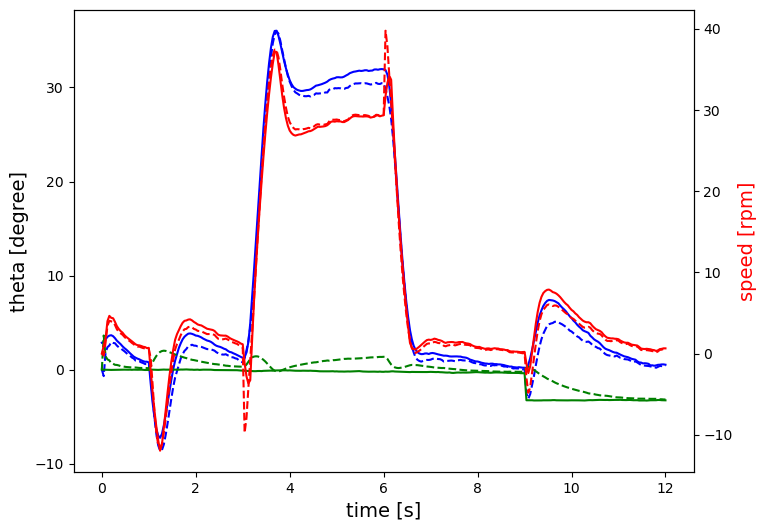

In [ ]:
R=25*10**-3
testObj=InvertedPendulumOnWheel(
    m=131.44*10**-3, # kg
    m_w=11.78*10**-3, # kg
    R=R, # m
    L=44.97*10**-3, # m
    I=409131.25*10**-9, # kg m^2
    I_w=3681.55*10**-9, # kg m^2
    Br=0.01, # kg m^2 /s
    Bm=0.01, # kg m^2 /s
)
testObj.PolePlacement(np.array([-6.9,-7.1,-30]))
event=[
    (1,'disturbance',np.array([[0,0,-1,0]]).T),
    (3,'setpoint',30/30*pi),
    (6,'setpoint',0.),
    (9,'disturbance',np.array([[0,0,0,-0.05]]).T),
]
timeVector,outputState,outputStateHat,torqueValue=testObj.Simulation(animation=True,duration=12,
    initialState=np.array([[0.05,0,0,0.0]]).T,acceleration=10,event=event,imageScale=1500,exportFileName='./gif/InvertedPendulumOnWheel.gif')
thetaValue=outputState[:,0]
phidotValue=outputState[:,1]
biasValue=outputState[:,3]
thetaHat=outputStateHat[:,0]
phidotHat=outputStateHat[:,1]
biasHat=outputStateHat[:,3]

plt.figure(figsize=(8,6))
plt.xlabel('time [s]', fontsize=14)
plt.plot(timeVector,thetaValue*180/pi, 'b')
plt.plot(timeVector,thetaHat*180/pi, 'b--')
plt.plot(timeVector,biasValue*180/pi, 'g')
plt.plot(timeVector,biasHat*180/pi, 'g--')
plt.ylabel('theta [degree]',fontsize=14)
rightax=plt.twinx()
rightax.plot(timeVector,phidotValue*30/pi, 'r')
rightax.plot(timeVector,phidotHat*30/pi, 'r--')
rightax.set_ylabel('speed [rpm]',fontsize=14)
# rightax.plot(timeVector,torqueValue, 'r')
# rightax.set_ylabel('torque [Nm]',fontsize=14)
rightax.yaxis.label.set_color('red')
plt.show()

## ReactionWheelOnInvertedPendulum

State: theta, phidot, thetadot, thetaBias
Input: torque in the "phi-theta" direction
output: theta, phidot-thetadot
set point state: phidot
Controllability:  3
Observability:  4


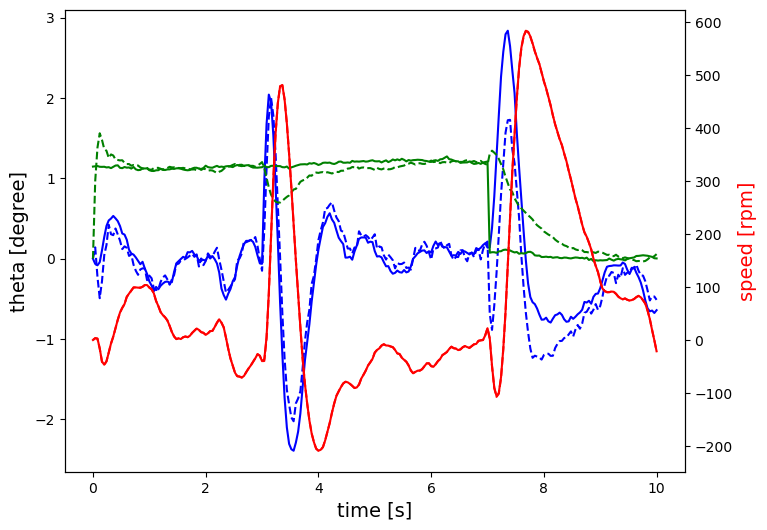

In [ ]:
testObj=ReactionWheelOnInvertedPendulum(
    m=114.34*10**-3, # kg
    m_w=28.88*10**-3, # kg
    L=60.27*10**-3, # m
    L_w=90*10**-3, # m
    I=541060.43*10**-9, # kg m^2
    I_w=29865.94*10**-9, # kg m^2
    Ba=0.01, # kg m^2 /s
    Bm=0.01, # kg m^2 /s
)
testObj.PolePlacement(np.array([-4.37226884+2.98271011j, -4.37226884-2.98271011j,-10]))

event=[
    (3,'disturbance',np.array([[0,0,0.5,0]]).T),
    (7,'disturbance',np.array([[0,0,0,-0.02]]).T),
]
timeVector,outputState,outputStateHat,torqueValue=testObj.Simulation(animation=True,duration=10,feedbackInterval=0.005,
    initialState=np.array([[0.0,0,0,0.02]]).T,acceleration=800,imageScale=2000,event=event,exportFileName='./gif/ReactionWheelOnInvertedPendulum.gif')
thetaValue=outputState[:,0]
phidotValue=outputState[:,1]
biasValue=outputState[:,3]
thetaHat=outputStateHat[:,0]
phidotHat=outputStateHat[:,1]
biasHat=outputStateHat[:,3]

plt.figure(figsize=(8,6))
plt.xlabel('time [s]', fontsize=14)
plt.plot(timeVector,thetaValue*180/pi, 'b')
plt.plot(timeVector,thetaHat*180/pi, 'b--')
plt.plot(timeVector,biasValue*180/pi, 'g')
plt.plot(timeVector,biasHat*180/pi, 'g--')
plt.ylabel('theta [degree]',fontsize=14)
# plt.ylim(-10,10)
rightax=plt.twinx()
rightax.plot(timeVector,phidotValue*30/pi, 'r')
rightax.plot(timeVector,phidotHat*30/pi, 'r--')
rightax.set_ylabel('speed [rpm]',fontsize=14)
# rightax.plot(timeVector,torqueValue, 'r')
# rightax.set_ylabel('torque [Nm]',fontsize=14)
rightax.yaxis.label.set_color('red')
plt.show()

## InvertedPendulumOnCart

State: theta, xdot, thetadot, thetaBias
Input: torque = R * force on x direction
output: theta, xdot
set point state: xdot
Controllability:  3
Observability:  4
Kr:  [[-0.6291375 -0.0834862 -0.0676972]]


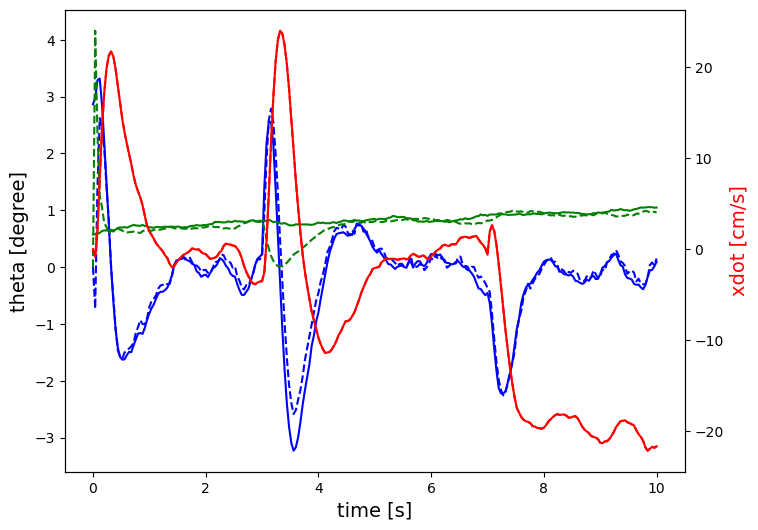

In [ ]:
mc=0.5
m1=0.1
l1=0.3
I1=1/12*m1*l1**2
testObj=InvertedPendulumOnCart(
    mc=mc, # kg
    m1=m1, # kg
    l1=l1, # m
    I1=I1, # kg m^2
    b1=0.01, # kg m^2 /s
    R=0.03, # m
)
# testObj.LQR(QW=np.diag([1,10,10]),RW=1)
testObj.PolePlacement(np.array([-5+1.j, -5-1.j,-10]))
print('Kr: ',testObj.Kr)
interval=0.04
event=[
    (3,'disturbance',np.array([[0,0,0.5,0]]).T),
    (7,'setpoint',-0.2),
]
timeVector,outputState,outputStateHat,torqueValue=testObj.Simulation(animation=True,duration=10,outputInterval=interval,
    initialState=np.array([[0.05,0,0,0.01]]).T,acceleration=1000,imageScale=500,event=event,exportFileName='./gif/InvertedPendulumOnCart.gif')
thetaValue=outputState[:,0]
xdotValue=outputState[:,1]
biasValue=outputState[:,3]
thetaHat=outputStateHat[:,0]
xdotHat=outputStateHat[:,1]
biasHat=outputStateHat[:,3]
x=0
xValue=[]
for i in range(xdotValue.shape[0]):
    x+=xdotValue[i]*interval
    xValue.append(x)
xValue=np.array(xValue)

plt.figure(figsize=(8,6))
plt.xlabel('time [s]', fontsize=14)
plt.plot(timeVector,thetaValue*180/pi, 'b')
plt.plot(timeVector,thetaHat*180/pi, 'b--')
plt.plot(timeVector,biasValue*180/pi, 'g')
plt.plot(timeVector,biasHat*180/pi, 'g--')
plt.ylabel('theta [degree]',fontsize=14)
rightax=plt.twinx()
rightax.plot(timeVector,xdotValue*100, 'r')
rightax.plot(timeVector,xdotHat*100, 'r--')
rightax.set_ylabel('xdot [cm/s]',fontsize=14)
# rightax.plot(timeVector,xValue*100, 'r')
# rightax.set_ylabel('x [cm]',fontsize=14)
# rightax.plot(timeVector,torqueValue, 'r')
# rightax.set_ylabel('torque [Nm]',fontsize=14)
rightax.yaxis.label.set_color('red')
plt.show()

## DoubleInvertedPendulumOnCart

In [11]:
m1=0.1
l1=0.3
I1=1/12*m1*l1**2
m2=0.1
l2=0.3
I2=1/12*m2*l2**2
# pendulum 2 has no effect
testObj=DoubleInvertedPendulumOnCart(
    mc=0.5, # kg
    m1=m1, # kg
    l1=l1, # m
    I1=I1, # kg m^2
    b1=0.01, # kg m^2 /s
    m2=0, # kg
    l2=0, # m
    I2=I2, # kg m^2
    b2=0.00, # kg m^2 /s
    R=0.03, # m
)
# state = theta,phi,xdot,thetadot,phidot  
testObj.SetKr(np.array([[-0.6291375,0,-0.0834862,-0.0676972,0]]))

State: theta, phi, xdot, thetadot, phidot
Input: torque = R * force on x direction
output: theta, phi-theta, xdot
set point state: xdot
Controllability:  3
Observability:  5
Eigenvalue:  [-9.9999425+0.j        -5.0000224+0.9999567j -5.0000224-0.9999567j
  0.       +0.j         0.       +0.j       ]


In [9]:
m1=0.1
l1=0.3
I1=1/12*m1*l1**2
m2=0.1
l2=0.3
I2=1/12*m2*l2**2
# pendulum 1 has no effect
testObj=DoubleInvertedPendulumOnCart(
    mc=0.5, # kg
    m1=0, # kg
    l1=0, # m
    I1=I1, # kg m^2
    b1=0.0, # kg m^2 /s
    m2=m2, # kg
    l2=l2, # m
    I2=I2, # kg m^2
    b2=0.01, # kg m^2 /s
    R=0.03, # m
)
# state = theta,phi,xdot,thetadot,phidot
testObj.SetKr(np.array([[0,-0.6291375,-0.0834862,0,-0.0676972]]))

State: theta, phi, xdot, thetadot, phidot
Input: torque = R * force on x direction
output: theta, phi-theta, xdot
set point state: xdot
Controllability:  3
Observability:  5
Eigenvalue:  [-9.9999425+0.j        -5.0000224+0.9999567j -5.0000224-0.9999567j
  0.       +0.j         0.       +0.j       ]


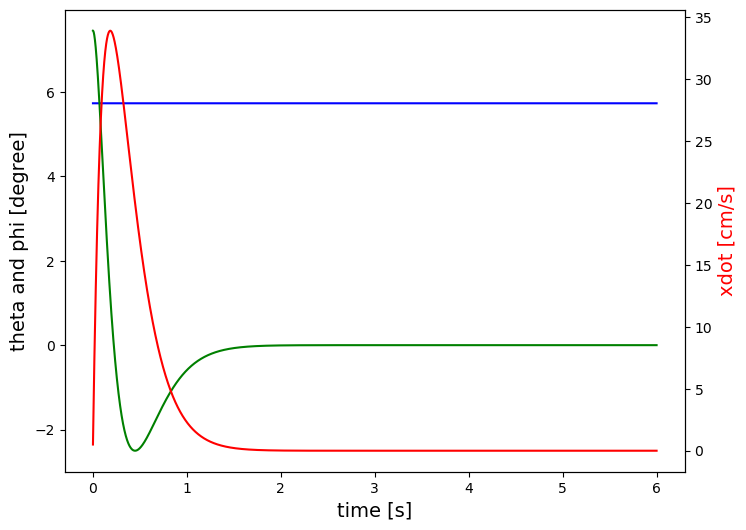

In [10]:
# state = theta,phi,xdot,thetadot,phidot
timeVector,outputState=testObj.SimulationSimple(duration=6,initialState=np.array([[0.1,0.13,0,0,0]]).T)
thetaValue=outputState[:,0]
phiValue=outputState[:,1]
xdotValue=outputState[:,2]
thetadotValue=outputState[:,3]
phidotValue=outputState[:,4]

plt.figure(figsize=(8,6))
plt.plot(timeVector,thetaValue*180/pi, 'b')
plt.plot(timeVector,phiValue*180/pi, 'g')
plt.xlabel('time [s]', fontsize=14)
plt.ylabel('theta and phi [degree]',fontsize=14)
rightax=plt.twinx()
rightax.plot(timeVector,xdotValue*100, 'r')
rightax.set_ylabel('xdot [cm/s]',fontsize=14)
rightax.yaxis.label.set_color('red')
plt.show()

In [14]:
m1=0.1
l1=0.3
I1=1/12*m1*l1**2
m2=0.1
l2=0.3
I2=1/12*m2*l2**2
testObj=DoubleInvertedPendulumOnCart(
    mc=0.5, # kg
    m1=m1, # kg
    l1=l1, # m
    I1=I1, # kg m^2
    b1=0.01, # kg m^2 /s
    m2=m2, # kg
    l2=l2, # m
    I2=I2, # kg m^2
    b2=0.01, # kg m^2 /s
    R=0.03, # m
)
# state = theta,phi,xdot,thetadot,phidot
testObj.LQR(QW=np.diag([10,100,10,1,1]),RW=1000)

State: theta, phi, xdot, thetadot, phidot
Input: torque = R * force on x direction
output: theta, phi-theta, xdot
set point state: xdot
Controllability:  5
Observability:  5
Eigenvalue:  [-22.5291706+0.j        -10.2652504+0.j         -6.7491239+2.6734846j
  -6.7491239-2.6734846j  -2.1341543+0.j       ]


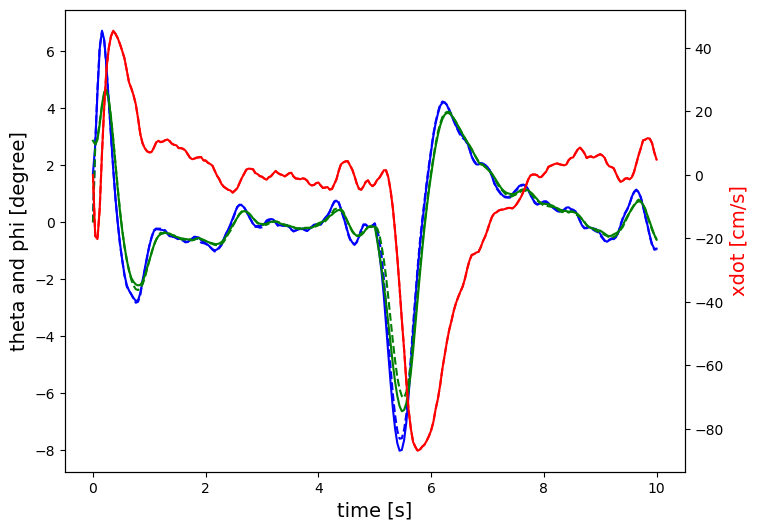

In [ ]:
event=[
    (5,'disturbance',np.array([[0,0,0,-0.2,-0.2]]).T)
]
timeVector,outputState,outputStateHat,torqueValue=testObj.Simulation(animation=True,duration=10,phyiscInterval=0.001,
    initialState=np.array([[0.03,0.05,0,0,0]]).T,QN=0.000001,acceleration=200,imageScale=300,event=event,exportFileName='./gif/DoubleInvertedPendulumOnCart.gif')
thetaValue=outputState[:,0]
phiValue=outputState[:,1]
xdotValue=outputState[:,2]
thetadotValue=outputState[:,3]
phidotValue=outputState[:,4]
thetaHat=outputStateHat[:,0]
phiHat=outputStateHat[:,1]
xdotHat=outputStateHat[:,2]
thetadotHat=outputStateHat[:,3]
phidotHat=outputStateHat[:,4]

plt.figure(figsize=(8,6))
plt.plot(timeVector,thetaValue*180/pi, 'b')
plt.plot(timeVector,thetaHat*180/pi, 'b--')
plt.plot(timeVector,phiValue*180/pi, 'g')
plt.plot(timeVector,phiHat*180/pi, 'g--')
plt.xlabel('time [s]', fontsize=14)
plt.ylabel('theta and phi [degree]',fontsize=14)
rightax=plt.twinx()
rightax.plot(timeVector,xdotValue*100, 'r')
rightax.plot(timeVector,xdotHat*100, 'r--')
rightax.set_ylabel('xdot [cm/s]',fontsize=14)
# rightax.plot(timeVector,torqueValue, 'r')
# rightax.set_ylabel('torque [Nm',fontsize=14)
rightax.yaxis.label.set_color('red')
plt.show()

## BallOnBeam

State: theta, R, Rdot, thetaBias
Input: thetadot
output: theta, R
set point state: R
Controllability:  3
Observability:  4


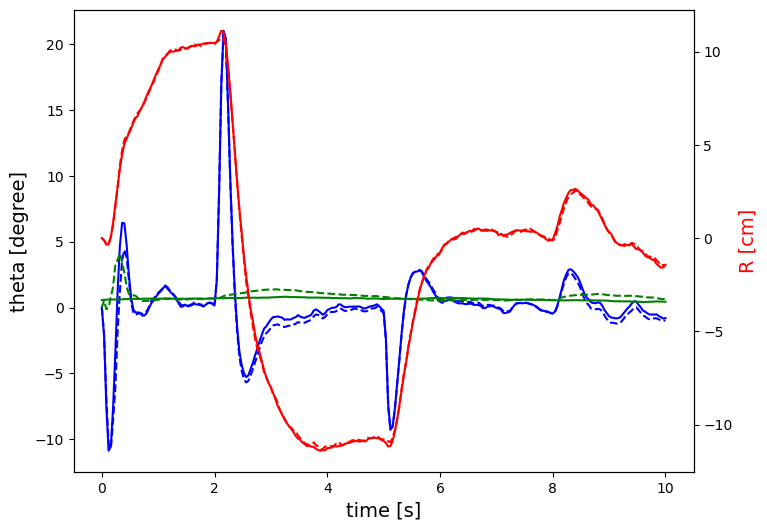

In [ ]:
testObj=BallOnBeam(
    m=30*10**-3, # kg
    r=0.02, # m
    d=0.03, # m
    I=0.001*3*10**-4, # kg m^2
    b=0.01, # kg/s=N/m*s
    ratio=5/7, # option: 1, 5/7, 25/49
)
testObj.PolePlacement(np.array([-4.37226884+2.98271011j, -4.37226884-2.98271011j,-10]))
event=[
    (2,'setpoint',-0.1),
    (5,'setpoint',0.),
    (8,'disturbance',np.array([[0,0,0.1,0.0]]).T),
]
timeVector,outputState,outputStateHat,torqueValue=testObj.Simulation(animation=False,duration=10,initialState=np.array([[0,0,0,0.01]]).T,
    setpoint=0.1,acceleration=50,imageScale=1500,event=event,exportFileName='./gif/BallOnBeam.gif')
thetaValue=outputState[:,0]
RValue=outputState[:,1]
biasValue=outputState[:,3]
thetaHat=outputStateHat[:,0]
RHat=outputStateHat[:,1]
biasHat=outputStateHat[:,3]

plt.figure(figsize=(8,6))
plt.xlabel('time [s]', fontsize=14)
plt.plot(timeVector,thetaValue*180/pi, 'b')
plt.plot(timeVector,thetaHat*180/pi, 'b--')
plt.plot(timeVector,biasValue*180/pi, 'g')
plt.plot(timeVector,biasHat*180/pi, 'g--')
plt.ylabel('theta [degree]',fontsize=14)
rightax=plt.twinx()
rightax.plot(timeVector,RValue*100, 'r')
rightax.plot(timeVector,RHat*100, 'r--')
rightax.set_ylabel('R [cm]',fontsize=14)
# rightax.plot(timeVector,torqueValue, 'r')
# rightax.set_ylabel('torque [Nm]',fontsize=14)
rightax.yaxis.label.set_color('red')
plt.show()

## ControlMomentGyroscope

State: theta, phi, thetadot, thetaBias
Input: phidot
output: theta, phi
set point state: phi
Controllability:  3
Observability:  4


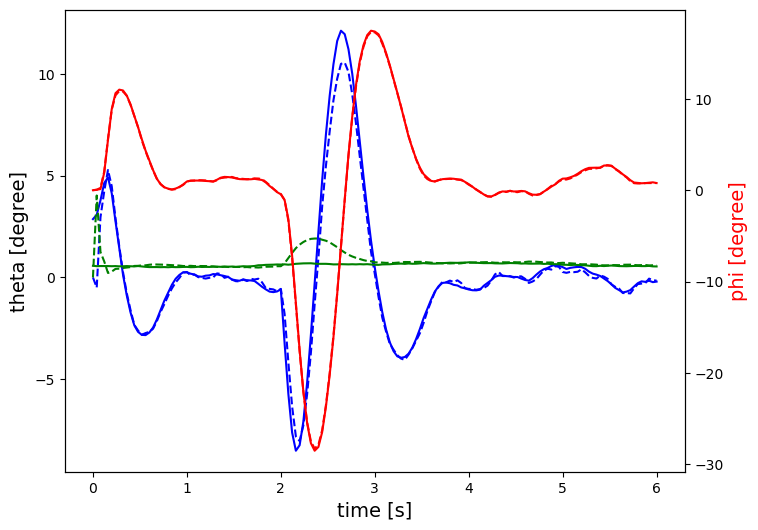

In [ ]:
r2=5*10**-2
r1=r2-1*10**-2
h=1*10**-2
m=pi*(r2**2-r1**2)*h*2.7*1000
mb=m/10
testObj=ControlMomentGyroscope(
    r2=r2, # m
    r1=r1, # m
    h=h, # m
    m=m, # m
    mb=mb, # kg
    r=10*10**-2, # m
    rb=5*10**-2, # m
    Bw=0.01, # kg m^2 /s
    psidot=600*pi/30, # 1/s
)
testObj.PolePlacement(np.array([-4.37226884+2.98271011j, -4.37226884-2.98271011j,-10]))
event=[
    (2,'disturbance',np.array([[0,0,-1.2,0]]).T),
]
timeVector,outputState,outputStateHat,torqueValue=testObj.Simulation(animation=True,duration=6,feedbackInterval=0.01,
    initialState=np.array([[0.05,0,0,0.01]]).T,acceleration=20,event=event,exportFileName='./gif/ControlMomentGyroscope.gif')
thetaValue=outputState[:,0]
phiValue=outputState[:,1]
biasValue=outputState[:,3]
thetaHat=outputStateHat[:,0]
phiHat=outputStateHat[:,1]
biasHat=outputStateHat[:,3]

plt.figure(figsize=(8,6))
plt.xlabel('time [s]', fontsize=14)
plt.plot(timeVector,thetaValue*180/pi, 'b')
plt.plot(timeVector,thetaHat*180/pi, 'b--')
plt.plot(timeVector,biasValue*180/pi, 'g')
plt.plot(timeVector,biasHat*180/pi, 'g--')
plt.ylabel('theta [degree]',fontsize=14)
# plt.ylim(-10,10)
rightax=plt.twinx()
rightax.plot(timeVector,phiValue*180/pi, 'r')
rightax.plot(timeVector,phiHat*180/pi, 'r--')
rightax.set_ylabel('phi [degree]',fontsize=14)
# rightax.plot(timeVector,torqueValue, 'r')
# rightax.set_ylabel('torque [Nm]',fontsize=14)
rightax.yaxis.label.set_color('red')

# Gyroscope

In [8]:
r2=5*10**-2
r1=r2-1*10**-2
h=1*10**-2
m=pi*(r2**2-r1**2)*h*2.7*1000
R=10*10**-2
p=9.81*m*R
Ixy=1/12*m*(3*(r2**2+r1**2)+h**2)+m*R**2
Iz=1/2*m*(r2**2+r1**2)
Ic=Iz-Ixy

In [236]:
interval=0.001
ratio=interval/0.0001
timeLength=3
timeVector=np.linspace(0,timeLength,int(timeLength/interval+1))

# q= Rz(phi) Rx(theta) Rz(psi)
theta0,thetadot0,phi0,phidot0=pi/8,0,0,-3
theta,thetadot,phi,phidot=theta0,thetadot0,phi0,phidot0
thetaTemp=theta
psidot=100
# psidot=(p-Ic*phidot**2*cos(theta))/(Iz*phidot) # this will make thetadot=0
# print(psidot)

E=Ixy/2*(phidot**2*sin(theta)**2+thetadot**2)+Iz/2*(phidot*cos(theta)+psidot)**2+p*cos(theta)
p_phi=(Ixy*sin(theta)**2+Iz*cos(theta)**2)*phidot+Iz*psidot*cos(theta)
p_psi=Iz*(phidot*cos(theta)+psidot)
E2=E-p_psi**2/2/Iz
print('p_phi: ',p_phi)
print('p_psi: ',p_psi)
print('E2: ',E2)

thetaValue=[]
thetadotValue=[]
phiValue=[]
phidotValue=[]
psidotValue=[]
error=[]

for i in range(int(timeLength/interval+1)):
    # plant
    for j in range(int(ratio)):
        deltatheta=0.0001*thetadot
        deltathetadot=0.0001*(1/2*phidot**2*sin(2*theta)+Iz/2/Ixy*(-phidot**2*sin(2*theta)-2*psidot*phidot*sin(theta))+1/Ixy*p*sin(theta))
        theta+=deltatheta
        thetadot+=deltathetadot
        # make sure E2 is const.
        if j==(int(ratio))-1:
            newE2=Ixy/2*thetadot**2+(p_phi-p_psi*cos(theta))**2/(2*Ixy*sin(theta)**2)+p*cos(theta)
            thetadot*=sqrt(E2/newE2)
            E3=E2-Ixy/2*thetadot**2
            y=0
            while True:
                slope=(p_phi-p_psi*cos(theta))*(p_psi-p_phi*cos(theta))/(Ixy*sin(theta)**3)-p*sin(theta)
                theta-=y/slope
                y=(p_phi-p_psi*cos(theta))**2/(2*Ixy*sin(theta)**2)+p*cos(theta)-E3
                if (1-0.01)<((y+E3+Ixy/2*thetadot**2)/E2)<(1+0.01):
                    break
        phidot=(p_phi-p_psi*cos(theta))/(Ixy*sin(theta)**2)
        phi+=phidot*0.0001
        psidot=p_psi/Iz-(p_phi-p_psi*cos(theta))*cos(theta)/(Ixy*sin(theta)**2)
    thetaValue.append(theta)
    thetadotValue.append(thetadot)
    phiValue.append(phi)
    phidotValue.append(phidot)
    psidotValue.append(psidot)

thetaValue=np.array(thetaValue)
thetadotValue=np.array(thetadotValue)
phiValue=np.array(phiValue)
phidotValue=np.array(phidotValue)
psidotValue=np.array(psidotValue)

p_phi:  0.013687778459032738
p_psi:  0.015216086692536082
E2:  0.06974462787832336


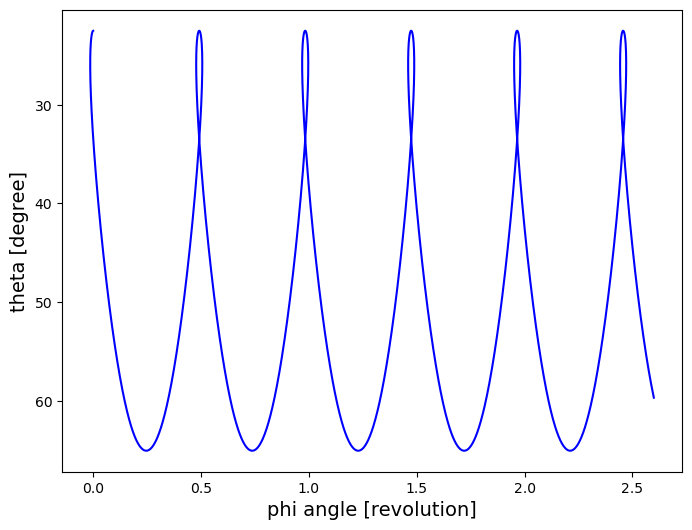

In [237]:
plt.figure(figsize=(8,6))
plt.plot(phiValue/2/pi,(thetaValue*180/pi)%360, 'b')
plt.ylabel('theta [degree]',fontsize=14)
plt.xlabel('phi angle [revolution]', fontsize=14)
plt.gca().invert_yaxis()
plt.show()

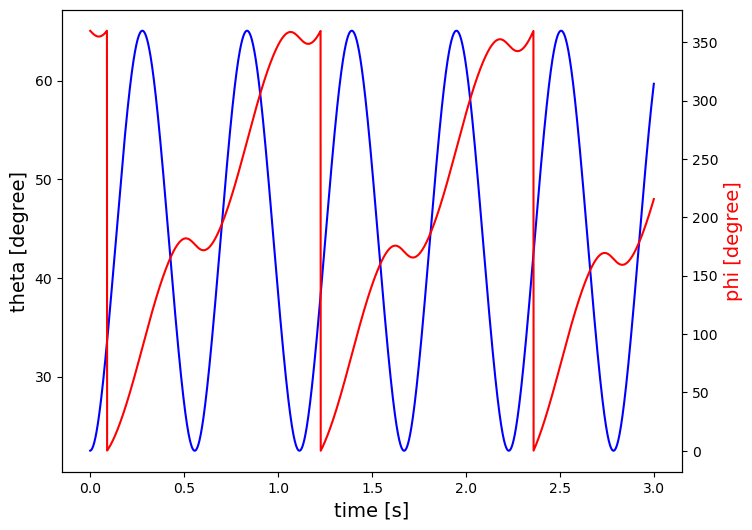

In [238]:
plt.figure(figsize=(8,6))
plt.plot(timeVector,(thetaValue*180/pi)%360, 'b')
plt.ylabel('theta [degree]',fontsize=14)
# plt.plot(timeVector,thetadotValue, 'b')
# plt.ylabel('thetadot [rad/s]',fontsize=14)
plt.xlabel('time [s]', fontsize=14)
rightax=plt.twinx()
plt.plot(timeVector,(phiValue*180/pi)%360, 'r')
plt.ylabel('phi [degree]',fontsize=14)
# rightax.plot(timeVector,phidotValue, 'r')
# rightax.set_ylabel('phidot [rad/s]',fontsize=14)
rightax.yaxis.label.set_color('red')
plt.show()

In [239]:
btheta=0.000
bphi=0.000
bpsi=0.00000
psidot=100
Acc=np.array([
    [p/Ixy,bpsi/Ixy*psidot,-btheta/Ixy,-Iz/Ixy*psidot],
    [0,p/Ixy,Iz/Ixy*psidot,-bphi/Ixy]
])
matrix=np.vstack((np.hstack((np.zeros((2,2)),np.identity(2))),Acc))
eigs=np.linalg.eig(matrix)[0]
print(eigs)

[ 1.61484531+9.29003021j  1.61484531-9.29003021j -1.61484531+9.29003021j
 -1.61484531-9.29003021j]


In [240]:
interval=0.001
ratio=interval/0.0001
timeLength=3
timeVector=np.linspace(0,timeLength,int(timeLength/interval+1))

# q= Rx(theta) Ry(phi) Rz(psi)
theta,thetadot,phi,phidot=theta0,thetadot0,phi0,phidot0*sin(theta0)
psidot=100

thetaValue=[]
thetadotValue=[]
phiValue=[]
phidotValue=[]
psidotValue=[]
error=[]

for i in range(int(timeLength/interval+1)):
    # plant
    for j in range(int(ratio)):
        deltatheta=0.0001*thetadot
        deltathetadot=0.0001*(-Iz*thetadot*phidot*sin(phi)+2*Ixy*thetadot*phidot*sin(phi)-Iz*psidot*phidot+p*sin(theta)-btheta/cos(phi)*thetadot+bpsi*np.tan(phi)*psidot)/(Ixy*cos(phi))
        deltaphi=0.0001*phidot
        deltaphidot=0.0001*(-1/2*thetadot**2*sin(2*phi)+Iz/Ixy/2*(thetadot**2*sin(2*phi)+2*psidot*thetadot*cos(phi))+1/Ixy*p*cos(theta)*sin(phi)-bphi/Ixy*phidot)
        deltapsidot=0.0001*(Iz*thetadot*phidot*sin(phi)**2-Ixy*thetadot*phidot*sin(phi)**2-Ixy*thetadot*phidot+Iz*psidot*phidot*sin(phi)-p*sin(theta)*sin(phi)+btheta*np.tan(phi)*thetadot-bpsi/Iz*psidot/cos(phi)*(Ixy*cos(phi)**2+Iz*sin(phi)**2))/(Ixy*cos(phi))
        theta+=deltatheta
        thetadot+=deltathetadot
        phi+=deltaphi
        phidot+=deltaphidot
        psidot+=deltapsidot
        
    thetaValue.append(theta)
    thetadotValue.append(thetadot)
    phiValue.append(phi)
    phidotValue.append(phidot)
    psidotValue.append(psidot)

thetaValue=np.array(thetaValue)
thetadotValue=np.array(thetadotValue)
phiValue=np.array(phiValue)
phidotValue=np.array(phidotValue)
psidotValue=np.array(psidotValue)

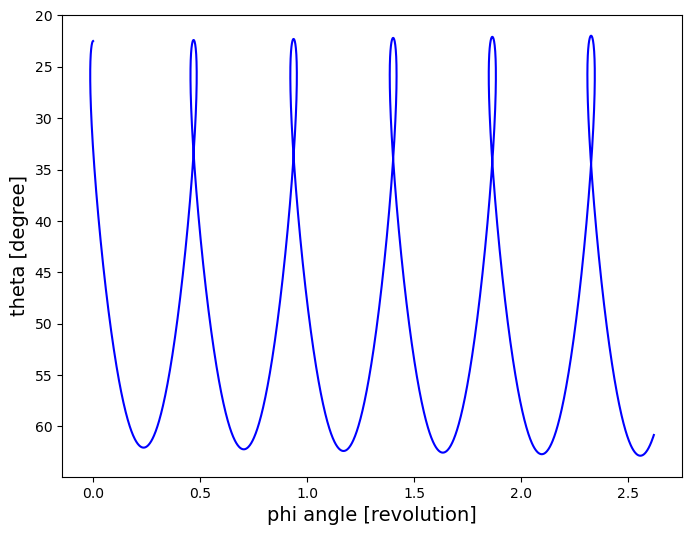

In [241]:
x=sin(phiValue)
y=-cos(phiValue)*sin(thetaValue)
z=cos(phiValue)*cos(thetaValue)
phi2=np.arctan2(x,-y)
theta2=np.arccos(z)
phiTemp=[phi2[0]]
bias=0
for i in range(1,phi2.shape[0]):
    if (phi2[i]+bias-phiTemp[-1])<-6:
        bias+=2*pi
    phiTemp.append(phi2[i]+bias)
phi2=np.array(phiTemp)
plt.figure(figsize=(8,6))
plt.plot(phi2/2/pi,(theta2*180/pi)%360, 'b')
plt.ylabel('theta [degree]',fontsize=14)
plt.xlabel('phi angle [revolution]', fontsize=14)
plt.gca().invert_yaxis()
plt.show()